# CNN для классификации текста

## CNN история

<img src="img/cats.png" alt="drawing" width="800"/>

Хайп вокруг CNN начался с [Alexnet](https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf)
<img src="img/alexnet.png" alt="drawing" width="800"/>

## 2d convolution

<img src="img/2d_convolution.gif" alt="drawing" width="400"/>
<img src="img/2d_activation.gif" alt="drawing" width="400"/>

* размер свертки
* stride 
* padding

## Pooling

<img src="img/maxpool.png" alt="drawing" width="600"/>

* max pooling
* average pooling
* k-max pooling

## CNN для текста

### 1d convolution

<img src="img/1d_convolution.png" alt="drawing" width="800"/>

### char cnn

<img src="img/1d_char.png" alt="drawing" width="600"/>

### Часто комбинируют свертки разного размера

<img src="img/1d_multy.png" alt="drawing" width="600"/>

## Хитрости

### Skip connection

<img src="img/residual.png" alt="drawing" width="600"/>

# Классификация текста при помощи TensorFlow Estimators

В этом ноубуке мы разберемся как использовать custom tensorflow estimators для классификации текста. 
Мы будем использовать tf.Data, tf.Estimator, tf.layers, word2vec эмбеддинги.


## Загрузка данных

### The IMDB Dataset

<img src="img/imdb.png" alt="drawing" width="400"/>

Мы будем использовать датасет IMDB [Large Movie Review Dataset](http://ai.stanford.edu/~amaas/data/sentiment/), 
который состоит из $25,000$ отзывов на популярные фильмы в обучающей выборке, и $25,000$ в тестовой выборке. Мы обучим модель для бинарной классификации, которая предсказывает является ли отзыв о фильме позитивным или негативным.

###  Заимпортим все необходимые бибилиотеки

In [1]:
import os
import string
import tempfile
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.python.keras.preprocessing import sequence
from tensorboard import summary as summary_lib

tf.logging.set_verbosity(tf.logging.INFO)
print(tf.__version__)

1.12.0


### Загрузка данных

Keras предоставляет возможность легко загружать некоторые датасеты (https://keras.io/datasets/) для удобства тестирования и бенчмаркинга архитектур

In [2]:
from tensorflow.python.keras.datasets import imdb

In [3]:
vocab_size = 5000
sentence_size = 200
embedding_size = 50
model_dir = tempfile.mkdtemp()

# первые индексы в словаре зарезервированы за специальными токенами 
# для паддинга, начала предложения, и для слов которые не вошли в словарь
pad_id = 0
start_id = 1
oov_id = 2
index_offset = 2

print("Loading data...")
(x_train_variable, y_train), (x_test_variable, y_test) = imdb.load_data(
    num_words=vocab_size, start_char=start_id, oov_char=oov_id,
    index_from=index_offset)
print(len(y_train), "train sequences")
print(len(y_test), "test sequences")

print("Pad sequences (samples x time)")
x_train = sequence.pad_sequences(x_train_variable, 
                                 maxlen=sentence_size,
                                 truncating='post',
                                 padding='post',
                                 value=pad_id)
x_test = sequence.pad_sequences(x_test_variable, 
                                maxlen=sentence_size,
                                truncating='post',
                                padding='post', 
                                value=pad_id)
print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)

Loading data...
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
x_train shape: (25000, 200)
x_test shape: (25000, 200)


По индексам слов можно получить их исходное представление чтобы посмотреть что было закодировано
(например в первом примере из  train)

In [4]:
word_index = imdb.get_word_index()
word_inverted_index = {v + index_offset: k for k, v in word_index.items()}

# Первые индексы в словаре зарезервированы для специальных токенов
word_inverted_index[pad_id] = '<PAD>'
word_inverted_index[start_id] = '<START>'
word_inverted_index[oov_id] = '<OOV>'

for i in range(0, 10):
    print(i, word_inverted_index[i])

def index_to_text(indexes):
    return ' '.join([word_inverted_index[i] for i in indexes])

print(index_to_text(x_train_variable[0]))

0 <PAD>
1 <START>
2 <OOV>
3 the
4 and
5 a
6 of
7 to
8 is
9 br
<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <OOV> is an amazing actor and now the same being director <OOV> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <OOV> and would recommend it to everyone to watch and the fly <OOV> was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <OOV> to the two little <OOV> that played the <OOV> of norman and paul they were just brilliant children are often left out of the <OOV> list i think because the stars that play them all grown up are such a big <OOV> for the whole film bu

In [5]:
x_train

array([[   1,   13,   21, ...,  225,   64,   15],
       [   1,  193, 1152, ...,    0,    0,    0],
       [   1,   13,   46, ...,    0,    0,    0],
       ...,
       [   1,   10,    5, ...,    0,    0,    0],
       [   1, 1445,    2, ...,    0,    0,    0],
       [   1,   16,    5, ...,    0,    0,    0]], dtype=int32)

## Tensorflow Estimator

В следующей секции мы разберем как создавать кастомные эстиматоры, как их обучать и делать предсказания

Детально о создании эстиматоров можно почитать [тут](https://developers.googleblog.com/2017/12/creating-custom-estimators-in-tensorflow.html)

### Пайплайн tf.data

### From arrays to tensors

Чтобы иметь возможность подавать данные в Tensorflow для обучения, данные нужно сконвертировать из numpy массивов в Tensors. Мы будем использовать для этого модуль `tf.data.Dataset`.

Мы используем функцию `from_tensor_slices` для создания объекта `Dataset`, к которому потом можно применять различные преобразования: перемешивание данных, упаковка в батчи, повторение процесса заданное количество итераций. 

Пайплайн `tf.data` содержит множество других функций для закрузки данных в модель, в том числе из данных сохраненных на диске. При этом весь менеджмент памяти и другие детали ложатся на tensorflow.

Для того, чтобы подавать данные в модель, нужно определить две функции: train_input_fn и eval_input_fn.
Одна используется для подачи данных для обучения модели, а вторая для подачи тестовых данных. 

In [6]:
x_len_train = np.array([min(len(x), sentence_size) for x in x_train_variable])
x_len_test = np.array([min(len(x), sentence_size) for x in x_test_variable])

def parser(x, length, y):
    features = {"x": x, "len": length}
    return features, y

def train_input_fn():
    # Подача данных для обучения
    dataset = tf.data.Dataset.from_tensor_slices((x_train, x_len_train, y_train))
    dataset = dataset.shuffle(buffer_size=len(x_train_variable))
    dataset = dataset.batch(100)
    dataset = dataset.map(parser)
    dataset = dataset.repeat()
    iterator = dataset.make_one_shot_iterator()
    return iterator.get_next()

def eval_input_fn():
    # Подача тестовых данных
    dataset = tf.data.Dataset.from_tensor_slices((x_test, x_len_test, y_test))
    dataset = dataset.batch(100)
    dataset = dataset.map(parser)
    iterator = dataset.make_one_shot_iterator()
    return iterator.get_next()

In [7]:
x_len_train

array([200, 189, 141, ..., 184, 150, 153])

In [8]:
x_train


array([[   1,   13,   21, ...,  225,   64,   15],
       [   1,  193, 1152, ...,    0,    0,    0],
       [   1,   13,   46, ...,    0,    0,    0],
       ...,
       [   1,   10,    5, ...,    0,    0,    0],
       [   1, 1445,    2, ...,    0,    0,    0],
       [   1,   16,    5, ...,    0,    0,    0]], dtype=int32)

### Бейзлайн

Попробуем решить задачу с использованием максимально простой линейной моделью для классификации текстов.
Линейная модель неучитывает порядок слов в предложении, поэтому подобные подходы называют Bag-of-Words (BOW, мешок слов).

В качестве фичей, подаваемых в модель, мы будем использовать `tf.feature_column`. Тут [хороший туториал](https://developers.googleblog.com/2017/11/introducing-tensorflow-feature-columns.html). В качестве модели будем использовать стандартный в TensorFlow `LinearClassifier`.

In [9]:
column = tf.feature_column.categorical_column_with_identity('x', vocab_size)
classifier = tf.estimator.LinearClassifier(feature_columns=[column], model_dir=os.path.join(model_dir, 'bow_sparse'))

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/var/folders/zw/2w6s_cjx4h9dj9fjz5t8tr800000gn/T/tmpugpr84q0/bow_sparse', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x12fcdb390>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


### Функция для скоринга модели

In [10]:
all_classifiers = {}
def train_and_evaluate(classifier):
    # Save a reference to the classifier to run predictions later
    all_classifiers[classifier.model_dir] = classifier
    classifier.train(input_fn=train_input_fn, steps=2500)
    eval_results = classifier.evaluate(input_fn=eval_input_fn)
    predictions = np.array([p['logistic'][0] for p in classifier.predict(input_fn=eval_input_fn)])
        
    # Reset the graph to be able to reuse name scopes
    tf.reset_default_graph() 
    # Add a PR summary in addition to the summaries that the classifier writes
    pr = summary_lib.pr_curve('precision_recall', predictions=predictions, labels=y_test.astype(bool), num_thresholds=21)
    with tf.Session() as sess:
        writer = tf.summary.FileWriter(os.path.join(classifier.model_dir, 'eval'), sess.graph)
        writer.add_summary(sess.run(pr), global_step=0)
        writer.close()

In [11]:
train_and_evaluate(classifier)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /var/folders/zw/2w6s_cjx4h9dj9fjz5t8tr800000gn/T/tmpugpr84q0/bow_sparse/model.ckpt.
INFO:tensorflow:loss = 69.31472, step = 1
INFO:tensorflow:global_step/sec: 105.687
INFO:tensorflow:loss = 39.33538, step = 101 (0.947 sec)
INFO:tensorflow:global_step/sec: 365.823
INFO:tensorflow:loss = 48.65559, step = 201 (0.273 sec)
INFO:tensorflow:global_step/sec: 307.77
INFO:tensorflow:loss = 26.427368, step = 301 (0.325 sec)
INFO:tensorflow:global_step/sec: 362.13
INFO:tensorflow:loss = 31.600616, step = 401 (0.276 sec)
INFO:tensorflow:global_step/sec: 308.063
INFO:tensorflow:loss = 24.079906, step = 501 (0.325 sec)
INFO:tensorflow:global_step/sec: 363.781
INFO:tensorflow:loss = 27.970974, step = 601 (0.275 sec)
INFO:te

Визуализируем, какие слова вносят наибольший вклад в результат предсказания модели

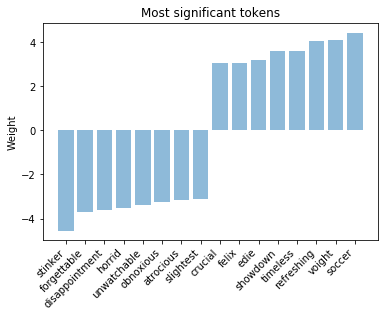

In [24]:
weights = classifier.get_variable_value('linear/linear_model/x/weights').flatten()
sorted_indexes = np.argsort(weights)
extremes = np.concatenate((sorted_indexes[-8:], sorted_indexes[:8]))
extreme_weights = sorted([(weights[i], word_inverted_index[i]) for i in extremes])

y_pos = np.arange(len(extreme_weights))
plt.bar(y_pos, [pair[0] for pair in extreme_weights], align='center', alpha=0.5)
plt.xticks(y_pos, [pair[1] for pair in extreme_weights], rotation=45, ha='right')
plt.ylabel('Weight')
plt.title('Most significant tokens') 
plt.show()

### Embeddings

Теперь добавим в наше решение эмбеддинги слов

In [25]:
word_embedding_column = tf.feature_column.embedding_column(column, dimension=embedding_size)
classifier = tf.estimator.DNNClassifier(
    hidden_units=[100],
    feature_columns=[word_embedding_column], 
    model_dir=os.path.join(model_dir, 'bow_embeddings'))
train_and_evaluate(classifier)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/var/folders/zw/2w6s_cjx4h9dj9fjz5t8tr800000gn/T/tmpwemhzmwh/bow_embeddings', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x13d7d1080>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorf

INFO:tensorflow:global_step/sec: 253.69
INFO:tensorflow:loss = 10.179875, step = 7101 (0.393 sec)
INFO:tensorflow:global_step/sec: 231.484
INFO:tensorflow:loss = 12.793192, step = 7201 (0.432 sec)
INFO:tensorflow:global_step/sec: 214.009
INFO:tensorflow:loss = 4.067693, step = 7301 (0.467 sec)
INFO:tensorflow:global_step/sec: 229.906
INFO:tensorflow:loss = 8.528903, step = 7401 (0.435 sec)
INFO:tensorflow:global_step/sec: 226.871
INFO:tensorflow:loss = 10.159124, step = 7501 (0.441 sec)
INFO:tensorflow:global_step/sec: 258.425
INFO:tensorflow:loss = 3.5287805, step = 7601 (0.387 sec)
INFO:tensorflow:global_step/sec: 238.92
INFO:tensorflow:loss = 7.590412, step = 7701 (0.419 sec)
INFO:tensorflow:global_step/sec: 220.605
INFO:tensorflow:loss = 3.8217783, step = 7801 (0.453 sec)
INFO:tensorflow:global_step/sec: 237.094
INFO:tensorflow:loss = 8.876156, step = 7901 (0.422 sec)
INFO:tensorflow:global_step/sec: 216.262
INFO:tensorflow:loss = 2.727556, step = 8001 (0.462 sec)
INFO:tensorflow:g

INFO:tensorflow:global_step/sec: 246.128
INFO:tensorflow:loss = 1.0129527, step = 15401 (0.406 sec)
INFO:tensorflow:global_step/sec: 224.825
INFO:tensorflow:loss = 0.80087864, step = 15501 (0.445 sec)
INFO:tensorflow:global_step/sec: 253.695
INFO:tensorflow:loss = 0.9187151, step = 15601 (0.394 sec)
INFO:tensorflow:global_step/sec: 253.645
INFO:tensorflow:loss = 1.243428, step = 15701 (0.394 sec)
INFO:tensorflow:global_step/sec: 209.774
INFO:tensorflow:loss = 1.1233305, step = 15801 (0.477 sec)
INFO:tensorflow:global_step/sec: 255.724
INFO:tensorflow:loss = 0.84714967, step = 15901 (0.391 sec)
INFO:tensorflow:global_step/sec: 225.118
INFO:tensorflow:loss = 0.8207511, step = 16001 (0.444 sec)
INFO:tensorflow:global_step/sec: 241.222
INFO:tensorflow:loss = 0.39254928, step = 16101 (0.415 sec)
INFO:tensorflow:global_step/sec: 219.971
INFO:tensorflow:loss = 0.9005867, step = 16201 (0.454 sec)
INFO:tensorflow:global_step/sec: 228.344
INFO:tensorflow:loss = 0.6766658, step = 16301 (0.438 sec

INFO:tensorflow:global_step/sec: 259.257
INFO:tensorflow:loss = 0.2739224, step = 23601 (0.386 sec)
INFO:tensorflow:global_step/sec: 236.002
INFO:tensorflow:loss = 0.18472819, step = 23701 (0.428 sec)
INFO:tensorflow:global_step/sec: 125.074
INFO:tensorflow:loss = 0.31682017, step = 23801 (0.796 sec)
INFO:tensorflow:global_step/sec: 222.995
INFO:tensorflow:loss = 0.10568954, step = 23901 (0.448 sec)
INFO:tensorflow:global_step/sec: 219.468
INFO:tensorflow:loss = 0.22410764, step = 24001 (0.456 sec)
INFO:tensorflow:global_step/sec: 240.895
INFO:tensorflow:loss = 0.16282889, step = 24101 (0.414 sec)
INFO:tensorflow:global_step/sec: 240.866
INFO:tensorflow:loss = 0.18643825, step = 24201 (0.416 sec)
INFO:tensorflow:global_step/sec: 219.074
INFO:tensorflow:loss = 0.22405721, step = 24301 (0.456 sec)
INFO:tensorflow:global_step/sec: 250.529
INFO:tensorflow:loss = 0.3045269, step = 24401 (0.399 sec)
INFO:tensorflow:global_step/sec: 225.263
INFO:tensorflow:loss = 0.18142346, step = 24501 (0.4

Визуализируем эмбеддинги при помощи [t-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding)

В TensorFlow для этого есть [standalone projector visualizer](http://projector.tensorflow.org)

In [12]:
with open(os.path.join(model_dir, 'metadata.tsv'), 'w', encoding="utf-8") as f:
    f.write('label\n')
    for index in range(0, vocab_size):
        f.write(word_inverted_index[index] + '\n')

### Convolutions

Применим 1d свертки по словам, чтобы предсказывать лучше

### Создание кастомного estimator`а

Фреймворк `tf.estimator`предоставляет высокоуровневые API для обучения ML моделей,методы `train()`, `evaluate()` и `predict()`, автоматическое сохранение чекпоинтов, методы загрузки, инициализации, сервинга модели, создание сессии и графа из коробки. 

Одно из важных преимуществ использования именно эстиматоров состоит в том, что один и тот же код можно использовать без изменений на CPU, GPU и даже распределенной конфигурации GPU.

В `tf` есть несколько простых стандартных эстиматоров. Но в большинстве случаев удобнее написть свой кастомный эстиматор, где можно использовать любую архитектуру нейронной сети. [Тут](https://www.tensorflow.org/extend/estimators) можно почитать хорошое объяснение про то как создавать кастомные эстиматоры.

In [13]:
head = tf.contrib.estimator.binary_classification_head()

def cnn_model_fn(features, labels, mode, params):    
    input_layer = tf.contrib.layers.embed_sequence(
        features['x'], vocab_size, embedding_size,
        initializer=params['embedding_initializer'])
    
    training = mode == tf.estimator.ModeKeys.TRAIN
    dropout_emb = tf.layers.dropout(inputs=input_layer, 
                                    rate=0.2, 
                                    training=training)

    conv = tf.layers.conv1d(
        inputs=dropout_emb,
        filters=32,
        kernel_size=3,
        padding="same",
        activation=tf.nn.relu)
    
    # Global Max Pooling
    pool = tf.reduce_max(input_tensor=conv, axis=1)
    
    hidden = tf.layers.dense(inputs=pool, units=250, activation=tf.nn.relu)
    
    dropout_hidden = tf.layers.dropout(inputs=hidden, 
                                       rate=0.2, 
                                       training=training)
    
    logits = tf.layers.dense(inputs=dropout_hidden, units=1)
    
    # This will be None when predicting
    if labels is not None:
        labels = tf.reshape(labels, [-1, 1])
    print(labels.shape)    

    optimizer = tf.train.AdamOptimizer()
    
    def _train_op_fn(loss):
        return optimizer.minimize(
            loss=loss,
            global_step=tf.train.get_global_step())

    return head.create_estimator_spec(
        features=features,
        labels=labels,
        mode=mode,
        logits=logits, 
        train_op_fn=_train_op_fn)
  
params = {'embedding_initializer': tf.random_uniform_initializer(-1.0, 1.0)}
cnn_classifier = tf.estimator.Estimator(model_fn=cnn_model_fn,
                                        model_dir=os.path.join(model_dir, 'cnn'),
                                        params=params)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/var/folders/zw/2w6s_cjx4h9dj9fjz5t8tr800000gn/T/tmpugpr84q0/cnn', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x13595b2e8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [14]:
train_and_evaluate(cnn_classifier)

INFO:tensorflow:Calling model_fn.
(?, 1)
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /var/folders/zw/2w6s_cjx4h9dj9fjz5t8tr800000gn/T/tmpugpr84q0/cnn/model.ckpt.
INFO:tensorflow:loss = 0.77835745, step = 1
INFO:tensorflow:global_step/sec: 24.3344
INFO:tensorflow:loss = 0.69506854, step = 101 (4.111 sec)
INFO:tensorflow:global_step/sec: 36.0765
INFO:tensorflow:loss = 0.645625, step = 201 (2.772 sec)
INFO:tensorflow:global_step/sec: 32.254
INFO:tensorflow:loss = 0.5851082, step = 301 (3.100 sec)
INFO:tensorflow:global_step/sec: 32.7492
INFO:tensorflow:loss = 0.5621565, step = 401 (3.054 sec)
INFO:tensorflow:global_step/sec: 35.952
INFO:tensorflow:loss = 0.5764883, step = 501 (2.781 sec)
INFO:tensorflow:global_step/sec: 28.5055
INFO:tensorflow:loss = 0.40669453, step = 601 (3.508 sec)
IN

AttributeError: 'NoneType' object has no attribute 'shape'

### Предобученные вектора

Попробуем исользовать предобученные эмбеддинги

In [ ]:
if not os.path.exists('glove.6B.zip'):
    ! wget http://nlp.stanford.edu/data/glove.6B.zip
if not os.path.exists('glove.6B.50d.txt'):
    ! unzip glove.6B.zip

--2019-02-19 15:34:09--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving proxy.tcsbank.ru (proxy.tcsbank.ru)... 10.218.11.51, 10.218.6.48, 10.218.6.49, ...
Connecting to proxy.tcsbank.ru (proxy.tcsbank.ru)|10.218.11.51|:8080... connected.
Proxy request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2019-02-19 15:34:10--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to proxy.tcsbank.ru (proxy.tcsbank.ru)|10.218.11.51|:8080... connected.
Proxy request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip         83%[===============>    ] 688.10M   669KB/s    eta 3m 40s 

In [ ]:
def load_glove_embeddings(path):
    embeddings = {}
    with open(path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.strip().split()
            w = values[0]
            vectors = np.asarray(values[1:], dtype='float32')
            embeddings[w] = vectors

    embedding_matrix = np.random.uniform(-1, 1, size=(vocab_size, embedding_size))
    num_loaded = 0
    for w, i in word_index.items():
        v = embeddings.get(w)
        if v is not None and i < vocab_size:
            embedding_matrix[i] = v
            num_loaded += 1
    print('Successfully loaded pretrained embeddings for '
          f'{num_loaded}/{vocab_size} words.')
    embedding_matrix = embedding_matrix.astype(np.float32)
    return embedding_matrix

embedding_matrix = load_glove_embeddings('glove.6B.50d.txt')

Для этого будем подавать в эстиматор инициализатор эмбеддингов

In [ ]:
def my_initializer(shape=None, dtype=tf.float32, partition_info=None):
    assert dtype is tf.float32
    return embedding_matrix

params = {'embedding_initializer': my_initializer}
cnn_pretrained_classifier = tf.estimator.Estimator(model_fn=cnn_model_fn,
                                        model_dir=os.path.join(model_dir, 'cnn_pretrained'),
                                        params=params)
train_and_evaluate(cnn_pretrained_classifier)

## Результаты

### Запуск TensorBoard

Проанализируем, какие метрии мы получили

Чтобы запустить tensorboard, нужно выполнить команду
```bash
> tensorboard --logdir={model_dir}
```

### Предсказания модели

Чтобы получить предсказания модели на новых примерах можно использовать метод `predict` у объекта `Estimator`, 
который подгружает последний сохранненный checkpoint для каждой модели и прогоняет через можель данные новых примеров. 

Но перед подачей данных в модель их нужно очистить, токенизировать и отобразить каждое слова в соответствущий ему индекс.

[!] Наличие только файла с сохраненной моделью не является достаточным, чтобы сгенерировать предсказания, т.к. код для создания эстиматора используется для сопоставления сохраненных весов и соответствующих тензоров в графе, поэтому хорошей практикой является сохранение модели в одной папке с кодом, который используется для ее создания. 

[!] Создание файла с моделью, которую можно полностью восстановить из файла возможно при помощи класса [SavedModel](https://www.tensorflow.org/programmers_guide/saved_model#using_savedmodel_with_estimators), 
который обычно используется при сохранении модели для сервинга [TensorFlow Serving](https://github.com/tensorflow/serving).

In [ ]:
def text_to_index(sentence):
    # Remove punctuation characters except for the apostrophe
    translator = str.maketrans('', '', string.punctuation.replace("'", ''))
    tokens = sentence.translate(translator).lower().split()
    return np.array([1] + [word_index[t] if t in word_index else oov_id for t in tokens])

def print_predictions(sentences):
    indexes = [text_to_index(sentence) for sentence in sentences]
    x = sequence.pad_sequences(indexes, 
                               maxlen=sentence_size, 
                               truncating='post',
                               padding='post',
                               value=pad_id)
    length = np.array([min(len(x), sentence_size) for x in indexes])
    predict_input_fn = tf.estimator.inputs.numpy_input_fn(x={"x": x, "len": length}, shuffle=False)
    predictions = {}
    for path, classifier in all_classifiers.items():
        predictions[path] = [p['logistic'][0] for p in classifier.predict(input_fn=predict_input_fn)]
    for idx, sentence in enumerate(sentences):
        print(sentence)
        for path in all_classifiers:
            print("\t{} {}".format(path, predictions[path][idx]))
            
print_predictions([
    'I really liked the movie!',
    'Hated every second of it...'])

### Список для чтения

Интуиция по работе CNN:
* Colah's [Understanding convolutions](http://colah.github.io/posts/2014-07-Understanding-Convolutions/)
* Colah's [Conv Nets: A Modular Perspective](http://colah.github.io/posts/2014-07-Conv-Nets-Modular/)
* [CS231n](http://cs231n.github.io/convolutional-networks/)

Туториалы:
* Как использовать TensorFlow Estimator API в различных задачах [tf-estimator-tutorials](https://github.com/GoogleCloudPlatform/tf-estimator-tutorials)

Со звездочкой:
* [Back Propagation in Convolutional Neural Networks — Intuition and Code](https://becominghuman.ai/back-propagation-in-convolutional-neural-networks-intuition-and-code-714ef1c38199)
* [Dilated Convolutions and Kronecker Factored Convolutions](https://www.inference.vc/dilated-convolutions-and-kronecker-factorisation/)